In [45]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.processors.altimeter import Altimeter
from mmwave_radar_processing.processors.velocity_estimator import VelocityEstimator
from mmwave_radar_processing.processors.range_resp import RangeProcessor
from mmwave_radar_processing.plotting.plotter_odometry_data import PlotterOdometryData
from mmwave_radar_processing.plotting.movies_odometry import MovieGeneratorOdometry

In [46]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"6843_RadVel_ods_10Hz.cfg")
cfg_manager.load_cfg(cfg_path,array_geometry="ods",array_direction="down")
cfg_manager.compute_radar_perforance(profile_idx=0)
print(f"Radar Range Resolution: {cfg_manager.range_res_m:.4f} m")

dataset_name = "CPSL_RadVel_ods_10Hz_1"#"CPSL_RadVel_ods_10Hz_1"#"CPSL_RadVel_ods_5Hz_diagonal"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

Radar Range Resolution: 0.0625 m
/data/RadVel/CPSL_RadVel_ods_10Hz_1
found 452 radar samples
did not find lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 452 vehicle velocity samples
found 452 vehicle odometry samples


In [47]:
plotter = PlotterOdometryData(config_manager=cfg_manager)
plotter.min_threshold_dB = 30

altimeter = Altimeter(
    config_manager=cfg_manager,
    min_altitude_m=25.0e-2, #15.0e-2 for 10Hz,20Hz
    zoom_search_region_m=20.0e-2,
    altitude_search_limit_m=40e-2, #20e-2
    range_bias=-0.13 #-0.13
)

velocity_estimator = VelocityEstimator(
    config_manager=cfg_manager,
    lower_range_bound=0.1,
    upper_range_bound=0.5,
    precise_vel_bound=0.50, #originally 0.20
    peak_threshold_dB=30.0,
    min_R2_threshold=0.80, #usually 0.90, 0.25 diagonal
    min_inlier_percent=0.80
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)


In [48]:
#initialize the movie generator
movie_generator = MovieGeneratorOdometry(
    cpsl_dataset=dataset,
    plotter=plotter,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1


100%|██████████| 452/452 [00:10<00:00, 41.42it/s]


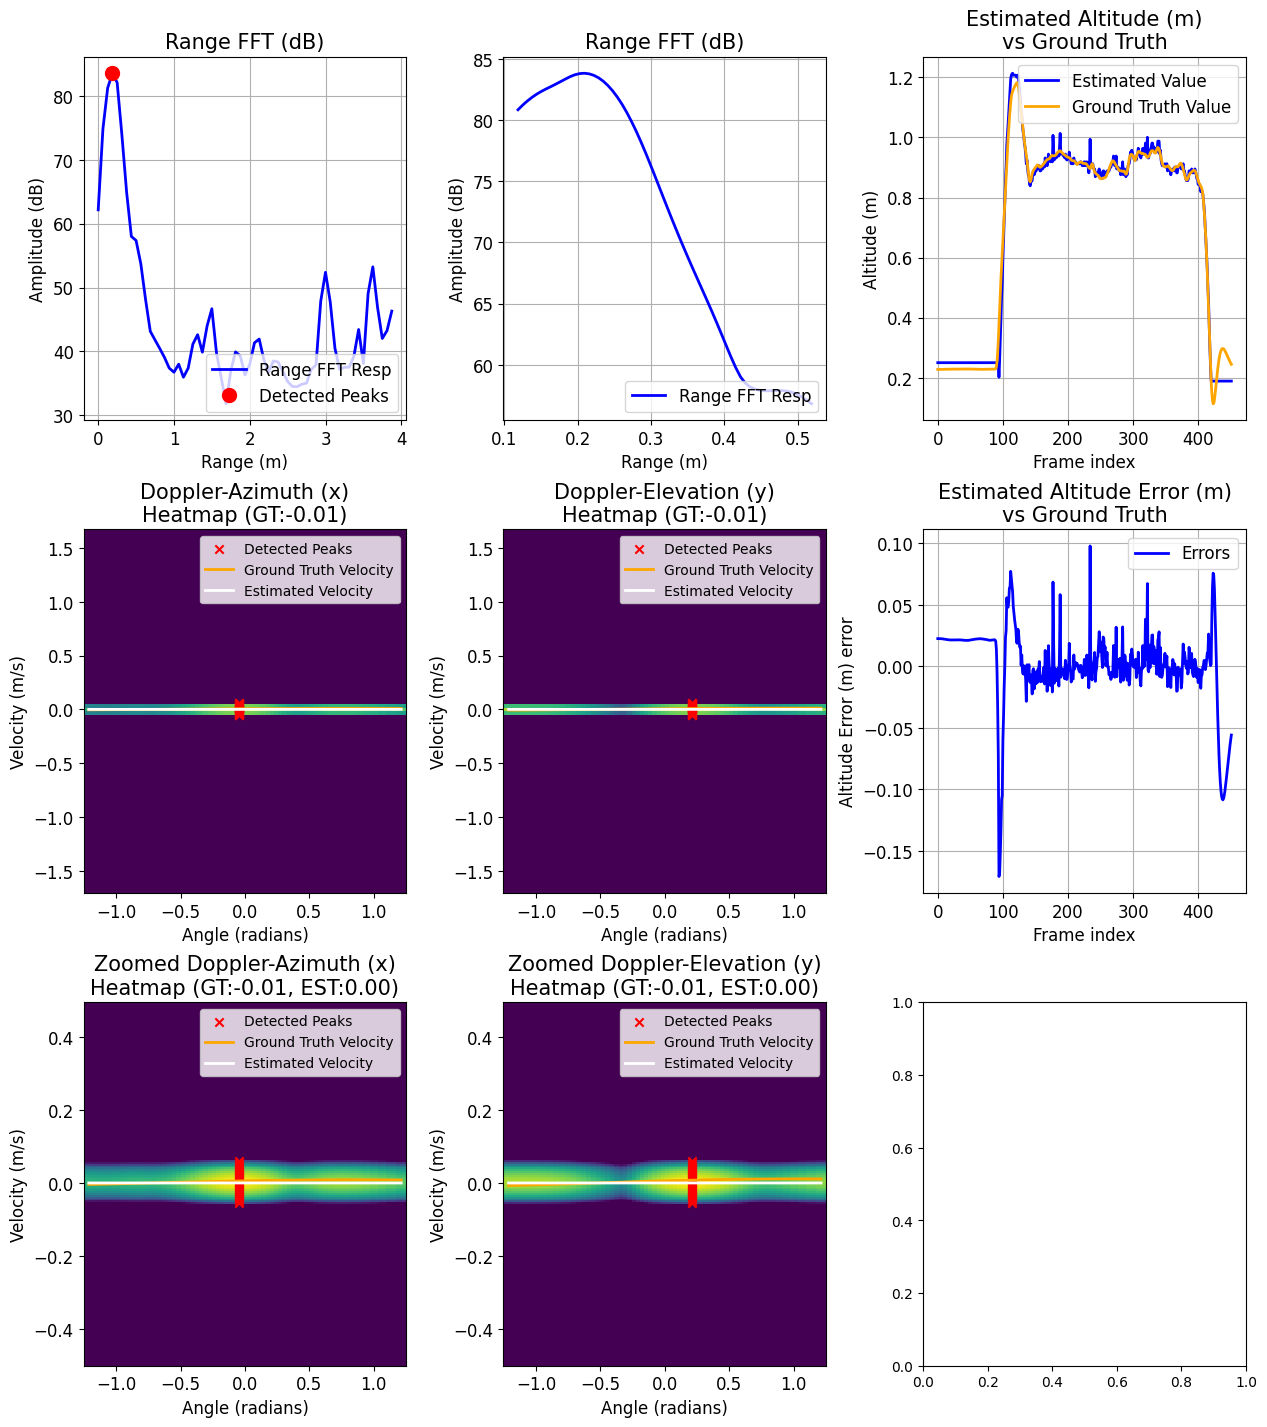

In [49]:
#for getting access to the adc cube
#good frames 10 Hz: 100 - takeoff 7- on ground 310 - moving
#good frames 5Hz diagonal: 80 
idx=dataset.num_frames#80#7#310#dataset.num_frames
altimeter.reset()
velocity_estimator.reset()
hist_test = []
#compute responses over a series of frames
#get the ADC cube

for i in tqdm(range(idx)):
    adc_cube = dataset.get_radar_data(i)
    adc_cube = virtual_array_reformatter.process(adc_cube)

    #estimate the altitude
    est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)
    
    #save the altitude history
    vehicle_odom = dataset.get_vehicle_odom_data(idx=i)
    gt_altitude = np.average(vehicle_odom[:, 3])
    altimeter.update_history(
        estimated=np.array([est_altitude]),
        ground_truth=np.array([gt_altitude])
    )


    #estimate the velocity
    vel_est = velocity_estimator.process(
        adc_cube=adc_cube,
        altitude=est_altitude,
        enable_precise_responses=True)
    
    #save the gt velocity history
    vehicle_vel_x = np.average(vehicle_odom[:,8])
    vehicle_vel_y = np.average(vehicle_odom[:,9])
    vehicle_vel_z = np.average(vehicle_odom[:,10])
    velocity_estimator.update_history(
        ground_truth=np.array([vehicle_vel_x,vehicle_vel_y,vehicle_vel_z]),
        estimated=vel_est
    )
    hist_test.append(vel_est)

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(3,3, figsize=(15,17))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    axs=axs,
    show=True
)

In [50]:
az_ego_vy_estimate,az_r2_inliers,az_inlier_ratio = velocity_estimator.lsq_fit_ego_vy_ransac_small_vx(
    peaks=velocity_estimator.azimuth_peaks
)
print(velocity_estimator.azimuth_peaks.shape)

el_ego_vy_estimate,el_r2_inliers,el_inlier_ratio = velocity_estimator.lsq_fit_ego_vy_ransac_small_vx(
    peaks=velocity_estimator.elevation_peaks
)

print(f"Azimuth Ego Vy Estimate: {az_ego_vy_estimate:.2f} m/s, R2 Inliers: {az_r2_inliers:.2f}, Inlier Ratio: {az_inlier_ratio:.2f}")
print(f"Elevation Ego Vy Estimate: {el_ego_vy_estimate:.2f} m/s, R2 Inliers: {el_r2_inliers:.2f}, Inlier Ratio: {el_inlier_ratio:.2f}")

az_ego_vy_estimate,az_r2_inliers,az_inlier_ratio = velocity_estimator.lsq_fit_ego_vy_ransac_standard(
    peaks=velocity_estimator.azimuth_peaks
)
print(velocity_estimator.azimuth_peaks.shape)

el_ego_vy_estimate,el_r2_inliers,el_inlier_ratio = velocity_estimator.lsq_fit_ego_vy_ransac_standard(
    peaks=velocity_estimator.elevation_peaks
)

print(f"Azimuth Ego Vy Estimate: {az_ego_vy_estimate:.2f} m/s, R2 Inliers: {az_r2_inliers:.2f}, Inlier Ratio: {az_inlier_ratio:.2f}")
print(f"Elevation Ego Vy Estimate: {el_ego_vy_estimate:.2f} m/s, R2 Inliers: {el_r2_inliers:.2f}, Inlier Ratio: {el_inlier_ratio:.2f}")

(24, 2)
Azimuth Ego Vy Estimate: 9.74 m/s, R2 Inliers: 0.00, Inlier Ratio: 1.00
Elevation Ego Vy Estimate: -0.20 m/s, R2 Inliers: -12218772460590167854701151780864.00, Inlier Ratio: 0.50
(24, 2)
Azimuth Ego Vy Estimate: 0.05 m/s, R2 Inliers: 0.00, Inlier Ratio: 1.00
Elevation Ego Vy Estimate: -0.01 m/s, R2 Inliers: 0.00, Inlier Ratio: 1.00


(200, 60)


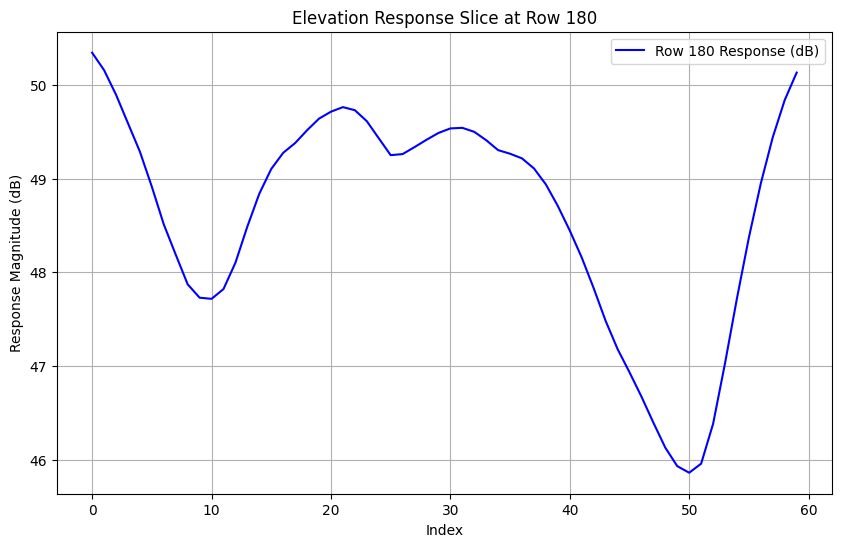

In [51]:
zoomed_el_resp = velocity_estimator.precise_elevation_response_mag
print(zoomed_el_resp.shape)
row_idx = 180

el_row_resp_dB = np.flip(20 * np.log10(zoomed_el_resp[row_idx,:]))

# Generate a plot of the response slice
plt.figure(figsize=(10, 6))
plt.plot(el_row_resp_dB, label=f"Row {row_idx} Response (dB)", color="blue")
plt.xlabel("Index")
plt.ylabel("Response Magnitude (dB)")
plt.title(f"Elevation Response Slice at Row {row_idx}")
plt.legend()
plt.grid(True)
plt.show()

Maximum Error: 0.008178318045061056
Average Error: 0.0020984839547756465


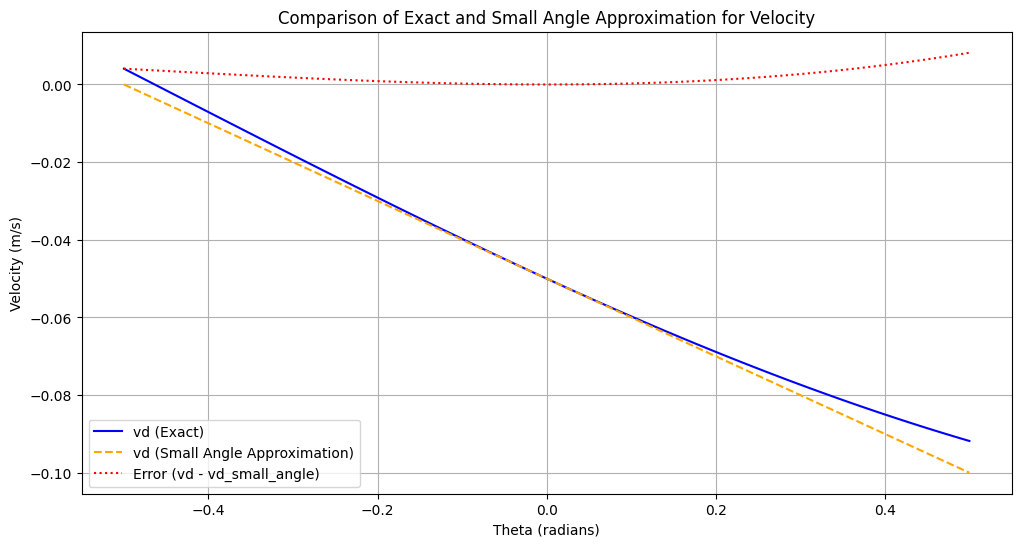

In [52]:
thetas = np.linspace(-0.5, 0.5, 100)
vx = 0.05
vy = 0.1
vd = -1 * vy * np.sin(thetas) - vx * np.cos(thetas)
vd_small_angle = -1 * vy * thetas - vx * 1

# Calculate the error
error = vd - vd_small_angle

# Print the maximum error
max_error = np.max(np.abs(error))
average_error = np.mean(np.abs(error))
print(f"Maximum Error: {max_error}")
print(f"Average Error: {average_error}")

# Plot the signals and the error
plt.figure(figsize=(12, 6))
plt.plot(thetas, vd, label="vd (Exact)", color="blue")
plt.plot(thetas, vd_small_angle, label="vd (Small Angle Approximation)", color="orange", linestyle="--")
plt.plot(thetas, error, label="Error (vd - vd_small_angle)", color="red", linestyle=":")
plt.xlabel("Theta (radians)")
plt.ylabel("Velocity (m/s)")
plt.title("Comparison of Exact and Small Angle Approximation for Velocity")
plt.legend()
plt.grid(True)
plt.show()




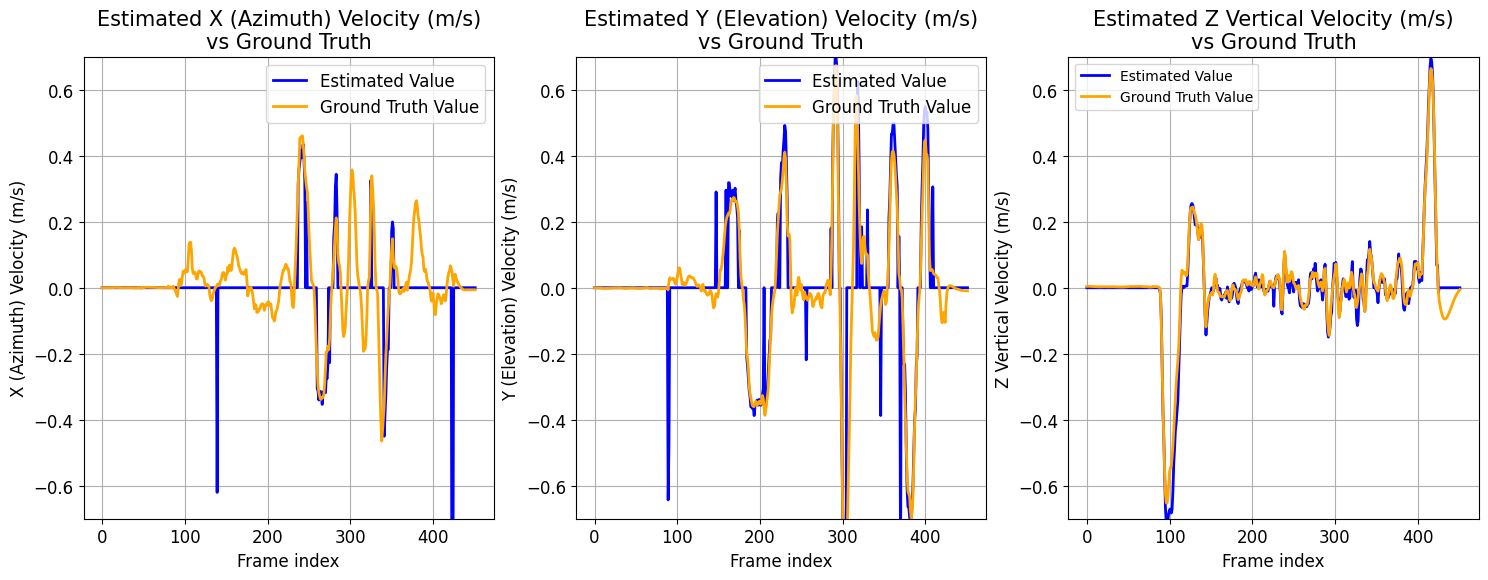

In [53]:
#comparing azimuth performance
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)
r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)

fig,ax = plt.subplots(1,3,figsize=(18,6))

vel_range = 0.7

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,0],
    ground_truth=vel_gt[:,1],
    value_label="X (Azimuth) Velocity (m/s)",
    ax=ax[0],
    show=False
)
ax[0].set_ylim([-vel_range,vel_range])

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,1],
    ground_truth=vel_gt[:,0],
    value_label="Y (Elevation) Velocity (m/s)",
    ax=ax[1],
    show=False
)
ax[1].set_ylim([-vel_range,vel_range])

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,2],
    ground_truth=-1 * vel_gt[:,2], #TODO: Fix this
    value_label="Z Vertical Velocity (m/s)",
    ax=ax[2],
    show=False
)
ax[2].set_ylim([-vel_range,vel_range])

# ax.plot(residuals[:,1],label="Elevation Residuals")
plt.legend()
plt.show()

Summary Statistics of Velocity Estimation Errors:
             Mean    Median      RMSE
X Error  0.060985  0.034195  0.123480
Y Error  0.054962  0.023396  0.116159
Z Error  0.018501  0.010580  0.030865
Norm     0.101545  0.062821  0.172317




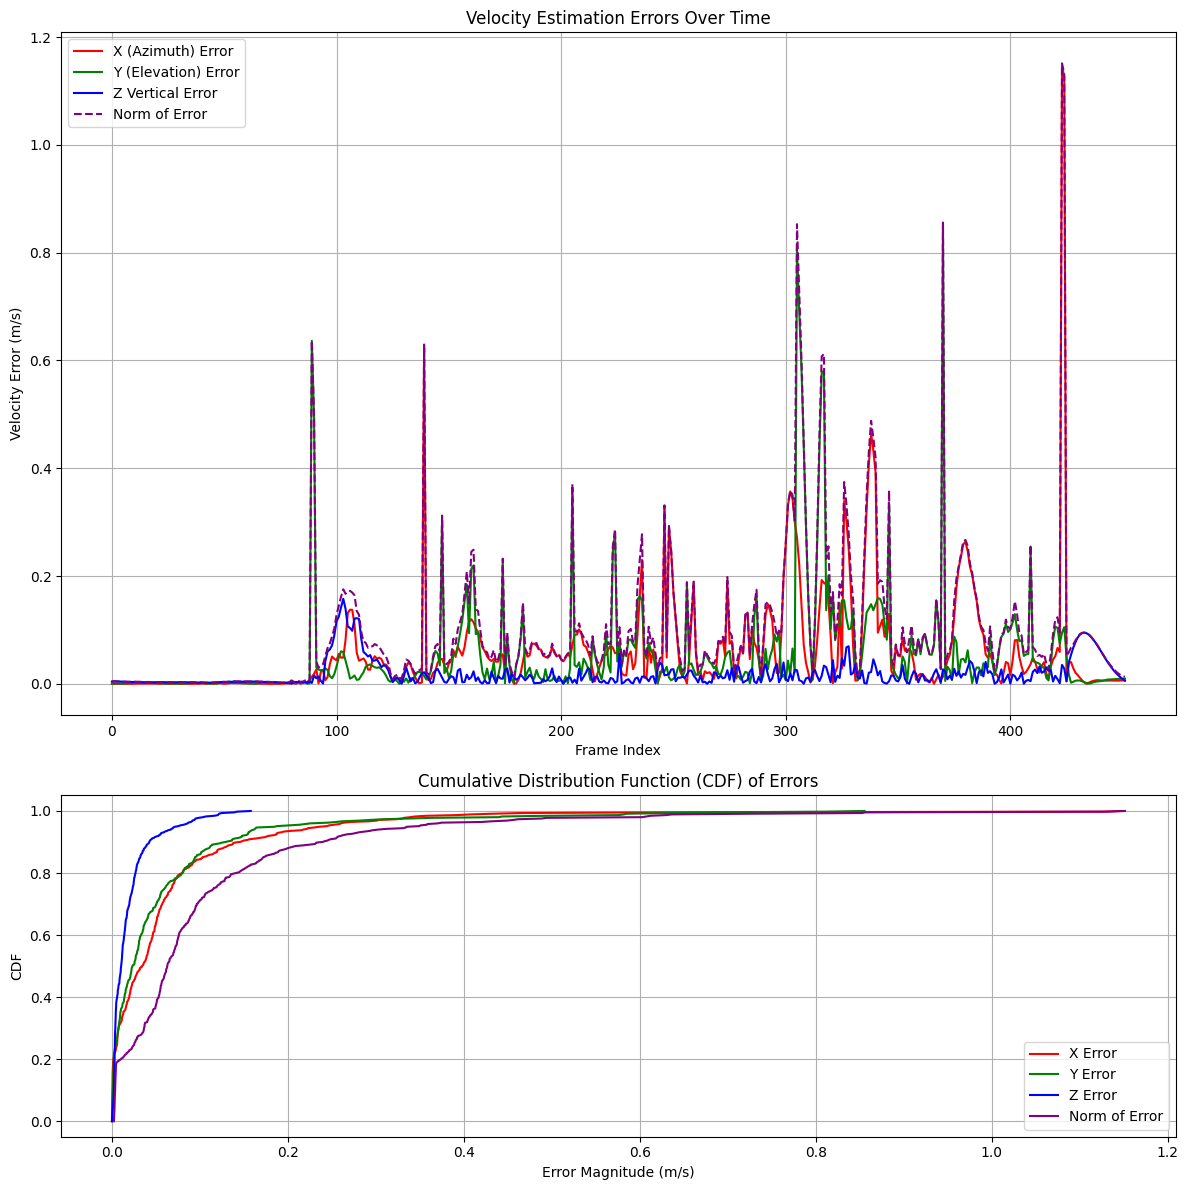

In [59]:
vel_est = np.stack(velocity_estimator.history_estimated, axis=0)
vel_gt = np.stack(velocity_estimator.history_gt, axis=0)

x_errors = np.abs(vel_est[:, 0] - vel_gt[:, 1])
y_errors = np.abs(vel_est[:, 1] - vel_gt[:, 0])
z_errors = np.abs(vel_est[:, 2] - -1 * vel_gt[:, 2])  # TODO: Fix this

# Compute the norm of the velocity error
norm_errors = np.sqrt(x_errors**2 + y_errors**2 + z_errors**2)

# Calculate summary statistics using pandas
errors_df = pd.DataFrame({
    "X Error": x_errors,
    "Y Error": y_errors,
    "Z Error": z_errors,
    "Norm": norm_errors
})

summary_stats = pd.DataFrame({
    "Mean": errors_df.mean(),
    "Median": errors_df.median(),
    "RMSE": np.sqrt((errors_df ** 2).mean())
})

print("Summary Statistics of Velocity Estimation Errors:")
print(summary_stats.to_string())
print("\n")

fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot errors over time
axs[0].plot(x_errors, label="X (Azimuth) Error", color="red")
axs[0].plot(y_errors, label="Y (Elevation) Error", color="green")
axs[0].plot(z_errors, label="Z Vertical Error", color="blue")
axs[0].plot(norm_errors, label="Norm of Error", color="purple", linestyle="--")
axs[0].set_xlabel("Frame Index")
axs[0].set_ylabel("Velocity Error (m/s)")
axs[0].set_title("Velocity Estimation Errors Over Time")
axs[0].legend()
axs[0].grid(True)

# Plot CDF for errors
for errors, label, color in zip(
    [x_errors, y_errors, z_errors, norm_errors],
    ["X Error", "Y Error", "Z Error", "Norm of Error"],
    ["red", "green", "blue", "purple"]
):
    sorted_errors = np.sort(errors)
    cdf = np.linspace(0, 1, len(sorted_errors))
    axs[1].plot(sorted_errors, cdf, label=label, color=color)

axs[1].set_xlabel("Error Magnitude (m/s)")
axs[1].set_ylabel("CDF")
axs[1].set_title("Cumulative Distribution Function (CDF) of Errors")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

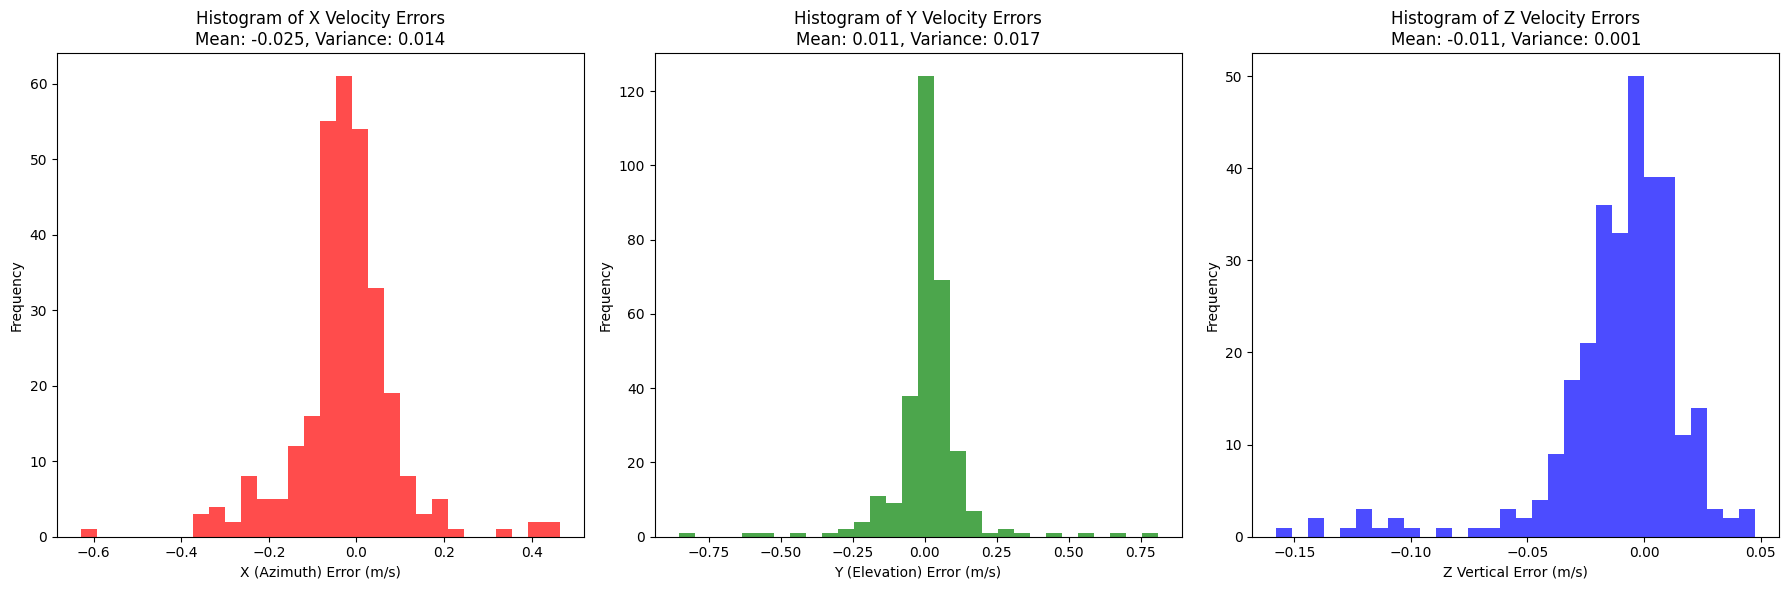

In [56]:
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_errors = vel_est[100:400,0] - vel_gt[100:400,1]
y_errors = vel_est[100:400,1] - vel_gt[100:400,0]
z_errors = vel_est[100:400,2] - -1 * vel_gt[100:400,2] #TODO: Fix this

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Calculate mean and variance for X errors
x_mean = np.mean(x_errors)
x_variance = np.var(x_errors)
axs[0].hist(x_errors, bins=30, color='red', alpha=0.7)
axs[0].set_xlabel("X (Azimuth) Error (m/s)")
axs[0].set_ylabel("Frequency")
axs[0].set_title(f"Histogram of X Velocity Errors\nMean: {x_mean:.3f}, Variance: {x_variance:.3f}")

# Calculate mean and variance for Y errors
y_mean = np.mean(y_errors)
y_variance = np.var(y_errors)
axs[1].hist(y_errors, bins=30, color='green', alpha=0.7)
axs[1].set_xlabel("Y (Elevation) Error (m/s)")
axs[1].set_ylabel("Frequency")
axs[1].set_title(f"Histogram of Y Velocity Errors\nMean: {y_mean:.3f}, Variance: {y_variance:.3f}")

# Calculate mean and variance for Z errors
z_mean = np.mean(z_errors)
z_variance = np.var(z_errors)
axs[2].hist(z_errors, bins=30, color='blue', alpha=0.7)
axs[2].set_xlabel("Z Vertical Error (m/s)")
axs[2].set_ylabel("Frequency")
axs[2].set_title(f"Histogram of Z Velocity Errors\nMean: {z_mean:.3f}, Variance: {z_variance:.3f}")

plt.tight_layout()
plt.show()

Error Metric    Value
  Mean Error 0.099814
Median Error 0.033796
  RMSE Error 0.249984




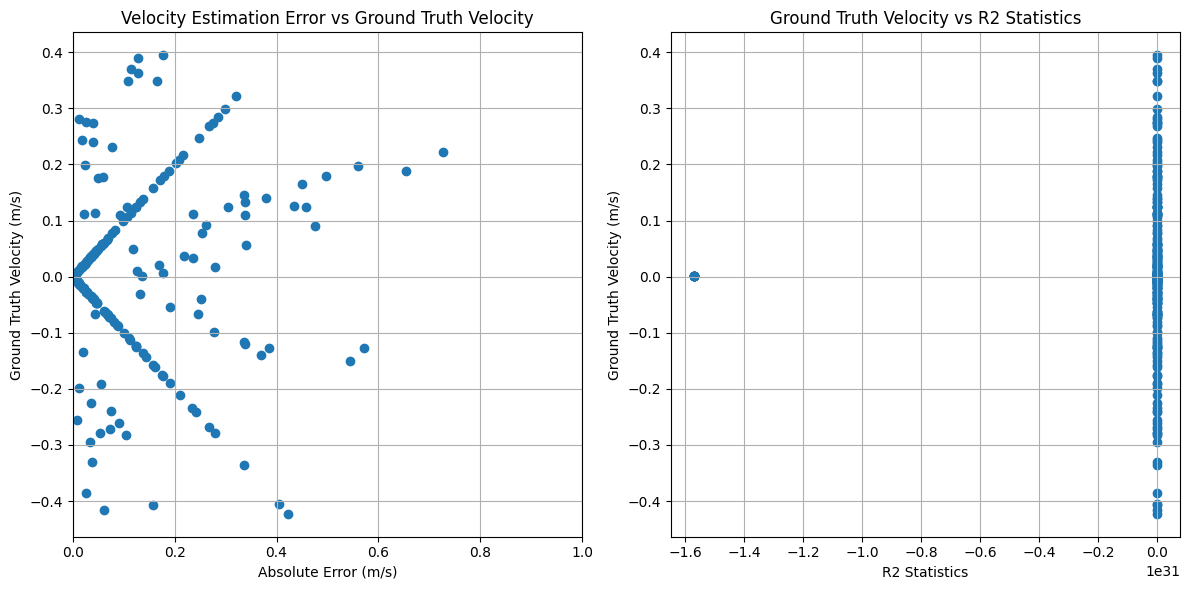

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_vel_est_az = vel_est[:,0]
x_vel_gt_az = vel_gt[:,1]
x_vel_est_el = vel_est[:,1]
x_vel_gt_el = vel_gt[:,0]

errors_az = np.abs(x_vel_est_az - x_vel_gt_az)
errors_el = np.abs(x_vel_est_el - x_vel_gt_el)

r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)
az_residuals = r2_statistics[:,0]
el_residuals = r2_statistics[:,1]

errors = np.concatenate([errors_az, errors_el])
vel_gt = np.concatenate([x_vel_gt_az, x_vel_gt_el])
r2_statistics = np.concatenate([az_residuals, el_residuals])

# errors = errors_az
# x_vel_gt = x_vel_gt_az

# Calculate mean, median, and RMSE
mean_error = np.mean(errors)
median_error = np.median(errors)
rmse_error = np.sqrt(np.mean(errors ** 2))

# Create a Pandas DataFrame for the table
table_data = {
    "Error Metric": ["Mean Error", "Median Error", "RMSE Error"],
    "Value": [mean_error, median_error, rmse_error]
}
table = pd.DataFrame(table_data)

print(table.to_string(index=False))
print("\n")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of errors vs ground truth
axs[0].scatter(errors, vel_gt)
axs[0].set_xlabel("Absolute Error (m/s)")
axs[0].set_ylabel("Ground Truth Velocity (m/s)")
axs[0].set_title("Velocity Estimation Error vs Ground Truth Velocity")
axs[0].grid(True)
axs[0].set_xlim(0,1)

# Scatter plot of ground truth vs residuals
axs[1].scatter(r2_statistics, vel_gt)
axs[1].set_xlabel("R2 Statistics")
axs[1].set_ylabel("Ground Truth Velocity (m/s)")
axs[1].set_title("Ground Truth Velocity vs R2 Statistics")
axs[1].grid(True)

plt.tight_layout()
plt.show()


(-1.0, 1.0)

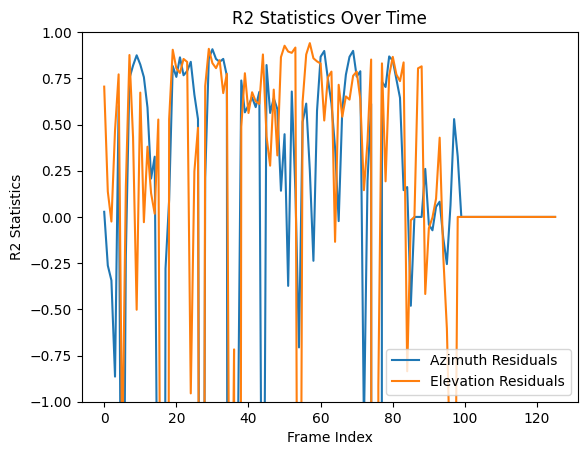

In [55]:
r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)
plt.plot(r2_statistics[20:,0],label="Azimuth Residuals")
plt.plot(r2_statistics[20:,1],label="Elevation Residuals")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("R2 Statistics")
plt.title("R2 Statistics Over Time")
plt.ylim([-1,1])

  0%|          | 0/146 [00:00<?, ?it/s]

  6%|▌         | 9/146 [00:04<01:13,  1.87it/s]/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
  9%|▉         | 13/146 [00:06<01:11,  1.87it/s]/home/david/Documents/mmwave_radar_processing/mmwave_radar_processing/plotting/plotter

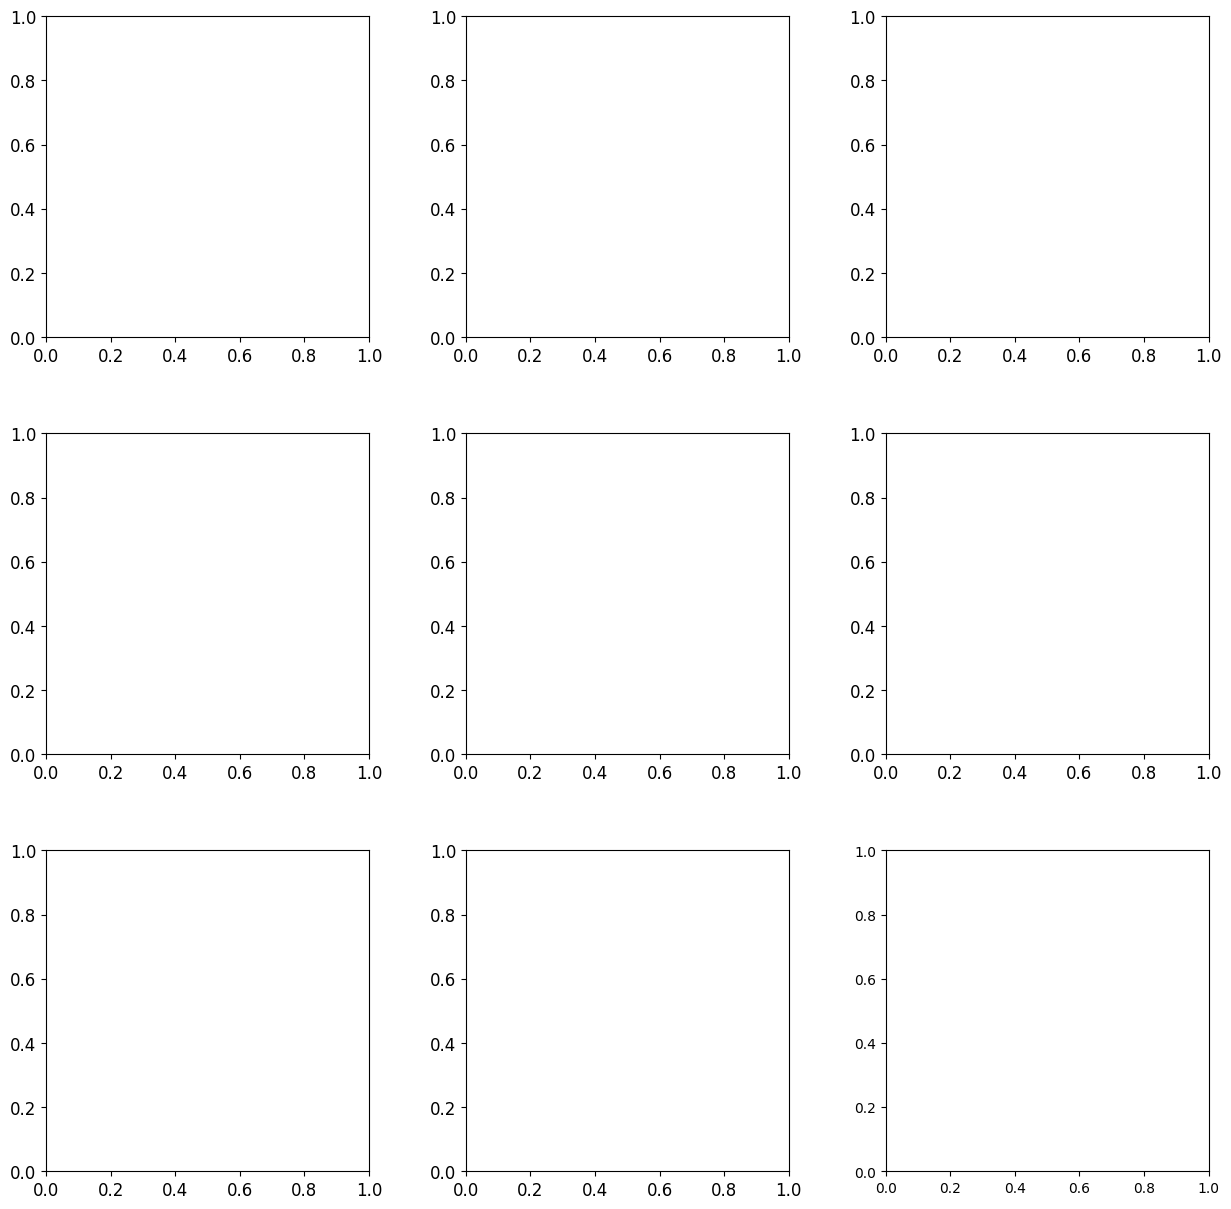

In [56]:
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

altimeter.reset()
velocity_estimator.reset()

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True
)
fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_altitude.mp4".format(dataset_name),fps=fps)